In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# COMPLETE PAPER PIPELINE **YOLOV5 + PDLPR**



#YOLOV5 INFERENCE

In [ ]:
!cp -r /content/drive/MyDrive/ccpd_green /content/

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.


In [ ]:
!pip install -r /content/yolov5/requirements.txt

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/train" --data inference_data.yaml --save-txt --save-crop  ## output canceled due to mega large size

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/val" --data inference_data.yaml --save-txt --save-crop  ## output canceled due to mega large size

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/test" --data inference_data.yaml --save-txt --save-crop  ## output canceled due to mega large size

# PDLPR

# Imports

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import re
import matplotlib.pyplot as plt
import time
import warnings

# Globals

In [ ]:
# TRANSFORMATIONS

transform = transforms.Compose([
    transforms.Resize((64, 256)), # Aspect ratio più realistico per targhe
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# GLOBALS NEEDED FOR ENCODING AND DECODING 

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

seen = set()   
MY_DICTIONARY = []
for char_list in [provinces, alphabets, ads]:
    for char in char_list:
        if char not in seen:
            MY_DICTIONARY.append(char)
            seen.add(char)

char2idx = {c: i for i, c in enumerate(MY_DICTIONARY)} # from characters to indices encoding
idx2char = {i: c for i, c in enumerate(MY_DICTIONARY)} # from indices to characters encoding
BLANK_IDX = len(MY_DICTIONARY)  

dictionary has 68 unique chars: ['皖', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑', '苏', '浙', '京', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤', '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁', '新', '警', '学', 'O', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
so i got (+1 for blank): 69 classes


In [ ]:
# CHECK ON DATASET STRUCTURE

def validate_dictionary():
    print("=== validating dict ===")
    print(f"Provinces: {len(provinces)} chars")
    print(f"Alphabets: {len(alphabets)} chars")
    print(f"Ads: {len(ads)} chars")
    print(f"Final dict: {len(MY_DICTIONARY)} unique chars")

    all_chars = set(provinces + alphabets + ads)
    dict_chars = set(MY_DICTIONARY)

    if all_chars == dict_chars:
        print("all chars are included in the dict")
    else:
        missing = all_chars - dict_chars
        extra = dict_chars - all_chars
        if missing:
            print(f"missing chars: {missing}")
        if extra:
            print(f"there's extra chars!: {extra}")

    # example file
    test_filename = "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
    print(f"\n=== Test Parsing ===")
    print(f"Test filename: {test_filename}")

    # parsing plate (method from the class)
    fields = test_filename.split('-')
    indices = fields[4].split("_")
    test_plate = provinces[int(indices[0])] + alphabets[int(indices[1])] + "".join([ads[int(i)] for i in indices[2:]])
    print(f"parsed plate: '{test_plate}'")

    # Verify i have all the chars in the dict
    missing_chars = [c for c in test_plate if c not in char2idx]
    if missing_chars:
        print(f"missing chars in dict: {missing_chars}")
    else:
        print("the dictionary is ok!")

validate_dictionary()

=== validating dict ===
Provinces: 34 chars
Alphabets: 25 chars
Ads: 35 chars
Final dict: 68 unique chars
all chars are included in the dict

=== Test Parsing ===
Test filename: 025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg
parsed plate: '皖AY339S'
the dictionary is ok!


# model architecture and utils

In [ ]:
# PDLPR MODEL FOLLOWING PAPER ARCHITECTURE

'''

We implemented the architecture described in the paper by following these modules:

IMPROVED GLOBAL FEATURE EXTRACTOR (IGFE), COMPOSED BY:

- 1 FOCUS STRUCTURE (SLICING CONCATENATED ALONG THE CHANNEL DIRECTION, S=2)
- 2 RESBLOCKS (2 RESIDUALLY CONNECTED CNN BLOCKS (LEAKY RELU, BATCH NORMALIZATION, S=1, K=3))
- 1 CONVDOWNSAMPLING BLOCKS (SAME CNN BLOCK IN RESBLOCKS BUT WITH S=2)
- 2 RESBLOCKS (2 RESIDUALLY CONNECTED CNN BLOCKS (LEAKY RELU, BATCH NORMALIZATION, S=1, K=3))
- 1 CONVDOWNSAMPLING BLOCKS (SAME CNN BLOCK IN RESBLOCKS BUT WITH S=2)

ENCODER, COMPOSED BY:

- POSITIONAL ENCODING                                               |
- 1 CNN BLOCK (SAME CNN BLOCK IN RESBLOCKS BUT WITH S=1, K=1, P=1)  |
- 1 MULTI-HEAD ATTENTION BLOCK                                      | X3
- 1 CNN BLOCK (SAME CNN BLOCK IN RESBLOCKS BUT WITH S=1, K=1, P=1)  |
- 1 ADD & NORM BLOCK                                                |

NOW INSTEAD OF A PARALLEL DECODER WE DECIDED TO SIMPLIFY THE APPROACH BY USING THE CTC LOSS, WHOSE OUTPUTS ARE GREEDY DECODED.
MORE INFORMATION ABOUT THIS CHOICE CAN BE FOUND IN THE PRESENTATION: "Presentazione_Computer_Vision.pdf"

'''


# FOCUS MODULE

class Focus(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, dropout=0.1):  
        super(Focus, self).__init__()  
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        patch1 = x[..., ::2, ::2]
        patch2 = x[..., ::2, 1::2]
        patch3 = x[..., 1::2, ::2]
        patch4 = x[..., 1::2, 1::2]
        x = torch.cat([patch1, patch2, patch3, patch4], dim=1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)

        return x

# CNN BLOCK USED IN RESBLOCKS AND IN THE DOWNSAMPLING PART

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )

# RESBLOCK

class ResBlock(nn.Module):
    def __init__(self, channels):  
        super(ResBlock, self).__init__()  
        self.block = nn.Sequential(
            conv_block(channels, channels),
            conv_block(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)

# FULL IMPROVED GLOBAL FEATURE EXTRACTOR MODULE

class IGFE(nn.Module):
    def __init__(self, dropout=0.1):  
        super(IGFE, self).__init__()  
        self.focus = Focus(1, 64, dropout)  
        self.down1 = conv_block(64, 128, stride=2)
        self.res1 = ResBlock(128)
        self.res2 = ResBlock(128)
        self.down2 = conv_block(128, 256, stride=2)
        self.res3 = ResBlock(256)
        self.res4 = ResBlock(256)
        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 18))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.focus(x)
        x = self.down1(x)
        x = self.dropout(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down2(x)
        x = self.dropout(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.final_conv(x)
        x = self.adaptive_pool(x)
        return x

# POSITIONAL ENCODING

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, height, width): 
        super().__init__()  
        self.pe = nn.Parameter(torch.randn(1, d_model, height, width))

    def forward(self, x):
        return x + self.pe

# ENCODER BLOCK

class EncoderBlock(nn.Module):
    def __init__(self, d_model):  
        super(EncoderBlock, self).__init__()  
        self.self_attn = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  

        attn_out, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))

        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))

        return x.transpose(1, 2).view(B, C, H, W)

# FULL PDLPR MODEL

class PDLPR(nn.Module):
    def __init__(self, num_classes, dropout=0.1):  
        super(PDLPR, self).__init__()  
        self.igfe = IGFE(dropout)
        self.pos_encoding = PositionalEncoding(512, 6, 18)
        self.encoder = nn.Sequential(*[EncoderBlock(512) for _ in range(3)])

        self.ctc_head = nn.Sequential(
            nn.Linear(512 * 6, 256),  
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.igfe(x)  
        x = self.pos_encoding(x)
        x = self.encoder(x)  

        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2)  
        x = x.contiguous().view(B, W, -1)  

        x = self.ctc_head(x)  
        x = x.permute(1, 0, 2)  

        return x

## Utils

In [ ]:
# COLLATE FUNCTION

def ctc_collate_fn(batch):

    '''

    basically what I do here is stacking all the images in a batch into a single tensor and
    then computing the len of each label (assuming different lenght plate can happen). (I could actually avoid this but it's more general)
    Finally just concatenating all the labels into a vector (pytorch CTC wantres them in a line, not list)
    then returning image-label-its lenght.
    I need this to tell CTC where labels finish and i do not care padding as CTC deals with that internally 

    '''

    images, labels = zip(*batch)
    images = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths

def get_plate(filename):

    '''

    Extract the ground truth text plate from an image (parse the file of the image, since the text is encoded there)

    '''

    fields = filename.split('-')

    text=str(fields[4])
    indices=text.split("_")
    province_character=provinces[int(indices[0])]
    alphabet_character=alphabets[int(indices[1])]
    ads_charachters=[ads[int(i)] for i in indices[2:]]
    plate_text=province_character+alphabet_character+"".join(ads_charachters)

    return plate_text



def ctc_greedy_decoder(output, idx2char, blank=BLANK_IDX):

    '''

    Now, I know the network returns probabilities, as it does a softmax with logits of characters.
    I need to transform that probability into an actual char to compose the plate.
    I take the argmax of the softmax (most prob char), remove blanks used by CTC and possible
    duplicates CTC can actually produce.
    At the end I simply use the  mappings char-index index-char deefined at the beginning to compose the plate.
    This is greedy as it just takes the argmax of every step --> should be enough

    '''

    out = output.permute(1, 0, 2)  
    pred_strings = []
    for probs in out:
        pred = probs.argmax(1).cpu().numpy()
        prev = -1
        pred_str = []
        for p in pred:
            if p != blank and p != prev:
                pred_str.append(idx2char[p])
            prev = p
        pred_strings.append(''.join(pred_str))
    return pred_strings

# TRAINING FUNCTION

def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    start_time = time.time()

    for batch_idx, (images, labels, label_lengths) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [W, B, num_classes]
        log_probs = outputs.log_softmax(2)
        input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long).to(device)

        loss = criterion(log_probs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch loss every 100 batches
        if batch_idx % 100 == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "epoch": epoch,
                "batch": batch_idx
            })

    avg_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    # Log epoch metrics
    wandb.log({
        "train_loss": avg_loss,
        "epoch_time": epoch_time,
        "epoch": epoch,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f} - Time: {epoch_time:.2f}s")
    return avg_loss


def evaluate(model, dataloader, device, epoch=None, verbose = False,):
    model.eval()
    total = 0
    correct = 0
    total_chars = 0
    correct_chars = 0
    start_time = time.time()

    # Metriche aggiuntive
    length_errors = 0
    province_correct = 0
    alphabet_correct = 0

    with torch.no_grad():
        for images, labels, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)

            # Get ground truth
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            # Calculate metrics
            for pred, gt in zip(pred_strings, gt_strings):
                if pred == gt:
                    correct += 1
                total += 1

                # Character-level accuracy
                min_len = min(len(pred), len(gt))
                correct_chars += sum([p == g for p, g in zip(pred[:min_len], gt[:min_len])])
                total_chars += len(gt)

                # Metriche aggiuntive
                if len(pred) != len(gt):
                    length_errors += 1

                # Accuracy per provincia (primo carattere)
                if len(pred) > 0 and len(gt) > 0 and pred[0] == gt[0]:
                    province_correct += 1

                # Accuracy per alfabeto (secondo carattere)
                if len(pred) > 1 and len(gt) > 1 and pred[1] == gt[1]:
                    alphabet_correct += 1


    # Calculate final metrics
    acc = correct / total if total > 0 else 0
    char_acc = correct_chars / total_chars if total_chars > 0 else 0
    eval_time = time.time() - start_time
    length_error_rate = length_errors / total if total > 0 else 0
    province_acc = province_correct / total if total > 0 else 0
    alphabet_acc = alphabet_correct / total if total > 0 else 0

    # Log validation metrics
    if epoch is not None:
        wandb.log({
            "val_accuracy": acc,
            "val_char_accuracy": char_acc,
            "val_time": eval_time,
            "epoch": epoch
        })

    print(f"Val Accuracy: {acc:.4f} - Char Accuracy: {char_acc:.4f} - Time: {eval_time:.2f}s")
    print(f"Length error rate: {length_error_rate:.4f} | Province acc: {province_acc:.4f} | Alphabet acc: {alphabet_acc:.4f}")
    return acc, char_acc

# Data

In [ ]:
# DATASET CLASS

class CarPlateDataset(Dataset):

    def __init__(self, img_dir, transform=None, cropped = False):
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = os.listdir(img_dir)
        self.cropped = cropped


    def __len__(self):
        return len(self.image_names)

    def parse_filename(self, filename):
        fields = filename.split('-')
        area = float(fields[0]) / 100  # filename encodes the area in percentage (ratio plate-no plate area), so divising by 100 gives me a 0-1 range
        tilt_degree = fields[1].split('_')
        h_tilt = int(tilt_degree[0])    # horizontal tilt degree
        v_tilt = int(tilt_degree[1])    #  vertical tilt degree
        tilt_list = np.array([h_tilt, v_tilt], dtype=np.float32)


        bbox_coords = fields[2].split('_')  #bounding box coordinates
        leftUp_bbox = bbox_coords[0].split('&')
        leftUp_bbox_x = int(leftUp_bbox[0])
        leftUp_bbox_y = int(leftUp_bbox[1])
        rightBottom_bbox = bbox_coords[1].split('&')
        rightDown_bbox_x = int(rightBottom_bbox[0])
        rightDown_bbox_y = int(rightBottom_bbox[1])
        bbox_coords_list = np.array([(leftUp_bbox_x, leftUp_bbox_y),
                                    (rightDown_bbox_x, rightDown_bbox_y)], dtype=np.float32)

        vertices = fields[3].split('_')  # vertices of the plate
        right_bottom_vertex = vertices[0].split('&')
        right_bottom_vertex_x = int(right_bottom_vertex[0])
        right_bottom_vertex_y = int(right_bottom_vertex[1])
        left_bottom_vertex = vertices[1].split('&')
        left_bottom_vertex_x = int(left_bottom_vertex[0])
        left_bottom_vertex_y = int(left_bottom_vertex[1])
        left_up_vertex = vertices[2].split('&')
        left_up_vertex_x = int(left_up_vertex[0])
        left_up_vertex_y = int(left_up_vertex[1])
        right_up_vertex = vertices[3].split('&')
        right_up_vertex_x = int(right_up_vertex[0])
        right_up_vertex_y = int(right_up_vertex[1])

        vertices_list = np.array([(left_bottom_vertex_x, left_bottom_vertex_y),
                                (right_bottom_vertex_x, right_bottom_vertex_y),
                                (right_up_vertex_x, right_up_vertex_y),
                                (left_up_vertex_x, left_up_vertex_y)], dtype=np.float32)

        # Usa le variabili globali invece di ridefinirle
        text=str(fields[4])
        indices=text.split("_")
        province_character=provinces[int(indices[0])]
        alphabet_character=alphabets[int(indices[1])]
        ads_charachters=[ads[int(i)] for i in indices[2:]]
        plate_text=province_character+alphabet_character+"".join(ads_charachters)

        brightness = int(fields[5])
        blurriness_str = fields[6].replace('.jpg', '')
        match = re.match(r'\d+', blurriness_str)
        if match:
            blurriness = int(match.group())
        else:
            print(f"[WARNING] File '{filename}': blurriness non standard '{fields[6]}', imposto a 0.")
            blurriness = 0

        lp_indexes = []
        for c in plate_text:
            if c in char2idx:
                lp_indexes.append(char2idx[c])
            else:
                print(f"[WARNING] Carattere non riconosciuto '{c}' in '{plate_text}'")

        return {
            'area': area,
            'tilt': tilt_list,
            'bbox_coords': bbox_coords_list,
            'vertices': vertices_list,
            'lp': plate_text,
            'lp_indexes': lp_indexes,
            'brightness': brightness,
            'blurriness': blurriness,
        }

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image
        image = Image.open(img_path)

        # Parse the filename to get the associated metadata
        metadata = self.parse_filename(img_name)

        if self.cropped:    # I use this dataset for both baselines, so I check if I need to skip detection part and use dataset bbox.
            # I can use the crop method of PIL, that crops the image using coords in this way: (left, upper, right, lower)
            '''
            left is the x-coordinate of the left edge.

            upper is the y-coordinate of the top edge.

            right is the x-coordinate of the right edge.

            lower is the y-coordinate of the bottom edge.
            seen on the online odcs of pillow
            '''
            bbox_coords = metadata['bbox_coords']

            left = int(bbox_coords[0][0])   # x-coordinate of the left edge
            upper = int(bbox_coords[0][1])  # y-coordinate of the top edge
            right = int(bbox_coords[1][0])  # x-coordinate of the right edge
            lower = int(bbox_coords[1][1])  # y-coordinate of the bottom edge

            image = image.crop((left, upper, right, lower))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(metadata['lp_indexes'], dtype=torch.long)  # Return the image and the license plate indexes as a tensor, for the CNN to elaborate

In [ ]:
# CHOOSE THE DATASET

train_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_train/crops/license_plate',
    transform=transform,
    cropped=False
)

val_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_val/crops/license_plate',
    transform=transform,
    cropped=False
)

test_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_test/crops/license_plate',
    transform=transform,
    cropped=False
)


# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 8341
Validation samples: 1790
Test samples: 1789


# Network

In [ ]:
# WEIGHT AND BIASES SETUP

wandb.init(
    project="pdlpr-license-plate-recognition",
    config={
        "architecture": "PDLPR",
        "dataset": "CCPD_green",
        "batch_size": 32,
        "learning_rate": 0.001,
        "epochs": 50,
        "optimizer": "Adam",
        "image_size": (64, 256),
        "num_classes": 69,
        "dropout": 0.1
    }
)


# MODEL SETUP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = PDLPR(num_classes=BLANK_IDX + 1, dropout=0.1).to(device)

def count_parameters(model):

    '''

    function that counts the number of trainable parameters  
    
    '''

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

# TRAINING SETUP

criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

Using device: cuda
Model has 13,774,469 trainable parameters
Model initialized successfully!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Train

In [ ]:
# TRAINING PARAMETERS

num_epochs = 15
best_val_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(train_loss)
    val_acc, val_char_acc = evaluate(model, val_loader, device, epoch, verbose=(epoch % 10 == 0))
    val_accuracies.append(val_acc)
    scheduler.step(train_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_char_acc': val_char_acc,
            'train_loss': train_loss,
        }, 'best_pdlpr_model.pth')

        # Log best model info to wandb
        wandb.log({
            "best_val_acc": best_val_acc,
            "best_epoch": epoch
        })

        print(f"New best model saved! Validation accuracy: {val_acc:.4f}")

     # Log summary metrics
    wandb.log({
        "epoch": epoch,
        "best_val_acc_so_far": best_val_acc
        })

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")


wandb.summary["final_best_val_acc"] = best_val_acc
wandb.summary["total_epochs"] = num_epochs

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")

wandb.finish()



--- Epoch 1/15 ---
Epoch 0 - Train Loss: 1.4395 - Time: 46.60s
Val Accuracy: 0.3223 - Char Accuracy: 0.8336 - Time: 4.59s
Length error rate: 0.0089 | Province acc: 0.9670 | Alphabet acc: 0.9771
New best model saved! Validation accuracy: 0.3223
Current LR: 0.001000

--- Epoch 2/15 ---
Epoch 1 - Train Loss: 0.2556 - Time: 45.27s
Val Accuracy: 0.7709 - Char Accuracy: 0.9440 - Time: 5.63s
Length error rate: 0.0028 | Province acc: 0.9709 | Alphabet acc: 0.9827
New best model saved! Validation accuracy: 0.7709
Current LR: 0.001000

--- Epoch 3/15 ---
Epoch 2 - Train Loss: 0.1604 - Time: 45.74s
Val Accuracy: 0.8117 - Char Accuracy: 0.9523 - Time: 5.12s
Length error rate: 0.0000 | Province acc: 0.9804 | Alphabet acc: 0.9832
New best model saved! Validation accuracy: 0.8117
Current LR: 0.001000

--- Epoch 4/15 ---
Epoch 3 - Train Loss: 0.1184 - Time: 46.29s
Val Accuracy: 0.8659 - Char Accuracy: 0.9647 - Time: 4.62s
Length error rate: 0.0000 | Province acc: 0.9804 | Alphabet acc: 0.9832
New bes

batch,▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁█
batch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,▁▁▂▃▃▅▅▇█
best_val_acc,▁▆▇▇█████
best_val_acc_so_far,▁▆▇▇███████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
epoch_time,█▁▃▆▇▇▆█▅▅▇▅▅▅▆
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇███▇███████
val_char_accuracy,▁▆▇▇███▇███████


# Evaluation

In [ ]:
# TESTING THE MODEL

if os.path.exists('best_pdlpr_model.pth'):
    checkpoint = torch.load('best_pdlpr_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.4f}")
else:
    print("No saved model found, using current model")

print("\n=== Final Test Results ===")
test_acc, test_char_acc = evaluate(model, test_loader, device, verbose=True)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Character Accuracy: {test_char_acc:.4f}")

# Test on a few sample images
def test_sample_predictions(model, test_loader, num_samples=5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(test_loader):
            if samples_shown >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)

            labels_cpu = labels.cpu().numpy()
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            for i, (pred, gt) in enumerate(zip(pred_strings, gt_strings)):
                if samples_shown >= num_samples:
                    break
                print(f"Sample {samples_shown+1}: Predicted: '{pred}' | Ground Truth: '{gt}' | Match: {pred == gt}")
                samples_shown += 1

            if samples_shown >= num_samples:
                break

print("\n=== Sample Predictions ===")
test_sample_predictions(model, test_loader, num_samples=10)

Loaded best model from epoch 14 with validation accuracy: 0.9196

=== Final Test Results ===
Val Accuracy: 0.9184 - Char Accuracy: 0.9778 - Time: 4.74s
Length error rate: 0.0006 | Province acc: 0.9911 | Alphabet acc: 0.9916

Final Test Accuracy: 0.9184
Final Test Character Accuracy: 0.9778

=== Sample Predictions ===
Sample 1: Predicted: '皖AD03128' | Ground Truth: '皖AD03128' | Match: True
Sample 2: Predicted: '皖AF11777' | Ground Truth: '皖AF11777' | Match: True
Sample 3: Predicted: '皖AD09814' | Ground Truth: '皖AD09814' | Match: True
Sample 4: Predicted: '皖AD05155' | Ground Truth: '皖AD05155' | Match: True
Sample 5: Predicted: '皖AD19535' | Ground Truth: '皖AD19535' | Match: True
Sample 6: Predicted: '皖AD80067' | Ground Truth: '皖AD80067' | Match: True
Sample 7: Predicted: '皖AD12821' | Ground Truth: '皖AD12821' | Match: True
Sample 8: Predicted: '皖AD60128' | Ground Truth: '皖AD60128' | Match: True
Sample 9: Predicted: '皖AD00020' | Ground Truth: '皖AF00752' | Match: False
Sample 10: Predicted: '

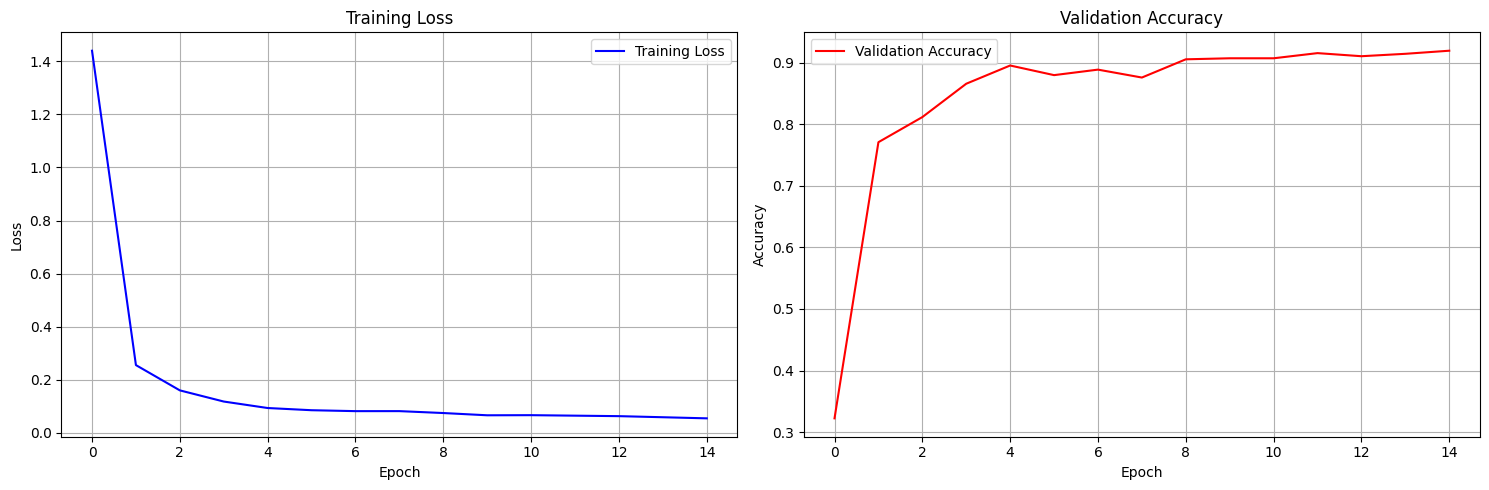


Inference Speed Test:
Average time per batch (32 images): 0.0042 seconds
Average time per image: 0.0001 seconds
Estimated FPS: 7690.19


In [ ]:
# VISUALIZE THE RESULTS

import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if 'train_losses' in locals() and 'val_accuracies' in locals():
    plot_training_curves(train_losses, val_accuracies)
else:
    print("No training data available for plotting")

import time

def test_inference_speed(model, test_loader, num_batches=10):
    model.eval()
    times = []

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(test_loader):
            if batch_idx >= num_batches:
                break

            images = images.to(device)

            # Time the forward pass
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            batch_time = end_time - start_time
            times.append(batch_time)

    avg_time = sum(times) / len(times)
    avg_per_image = avg_time / images.size(0)

    print(f"\nInference Speed Test:")
    print(f"Average time per batch ({images.size(0)} images): {avg_time:.4f} seconds")
    print(f"Average time per image: {avg_per_image:.4f} seconds")
    print(f"Estimated FPS: {1/avg_per_image:.2f}")

# Test inference speed if test_loader exists
if 'test_loader' in locals():
    test_inference_speed(model, test_loader)
else:
    print("No test loader available for speed test")

So yolo inference time was roughly 10ms per image on average, plus the average 1ms of pdlpr inference = about 11ms for the complete pipeline.
So about 110 FPS

# ONLINE PIPELINE

In [ ]:
# ONLINE PIPELINE

class LicensePlateRecognitionPipeline:
    def __init__(self, yolo_model_path, pdlpr_model_path, device='cuda'):

        """

        Pipeline completa per detection e riconoscimento targhe

        Args:
            yolo_model_path: Path al modello YOLOv5 addestrato
            pdlpr_model_path: Path al modello PDLPR addestrato
            device: Device da usare ('cuda' o 'cpu')

        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Carica modello YOLOv5
        self.yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=yolo_model_path)
        self.yolo_model.to(self.device)
        self.yolo_model.eval()

        # Carica modello PDLPR
        self.pdlpr_model = PDLPR(num_classes=BLANK_IDX + 1, dropout=0.1).to(self.device)
        checkpoint = torch.load(pdlpr_model_path, map_location=self.device)
        self.pdlpr_model.load_state_dict(checkpoint['model_state_dict'])
        self.pdlpr_model.eval()

        # Transforms per PDLPR
        self.transform = transforms.Compose([
            transforms.Resize((64, 256)),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        print("Pipeline initialized successfully!")

    def yolo_crop(self, image_path):

        """

        detecting plates through Yolo

        """

        img = Image.open(image_path)
        ris = self.yolo_model(image_path)  
        metadata = ris.pred[0]

        if len(metadata) > 0:
            det = metadata[0]  # Prima detection
            x1, y1, x2, y2 = map(int, det[:4])
            cropped = img.crop((x1, y1, x2, y2))
            return cropped
        else:
            print("Nessuna targa rilevata!")
            return None

    def recognize_plate(self, plate_crop):

        """

        Riconosce il testo di una targa usando PDLPR

        """

        if plate_crop is None:
            return ""

        plate_crop_tr = self.transform(plate_crop).unsqueeze(0)
        plate_crop_tr = plate_crop_tr.to(self.device)

        with torch.no_grad():
            outputs = self.pdlpr_model(plate_crop_tr)  # Usa self.pdlpr_model
            pred_string = ctc_greedy_decoder(outputs, idx2char)

        return pred_string[0] if pred_string else ""

    def __call__(self, img_path):

        """

        Rende l'oggetto callable (we were getting "(name of the object) not callable")

        """
        
        crop = self.yolo_crop(img_path)
        plate = self.recognize_plate(crop)
        return plate


In [ ]:
online_model = LicensePlateRecognitionPipeline(yolo_model_path = "/content/yolo_finetuned_model.pt", pdlpr_model_path = "/content/best_pdlpr_model.pth", device = "cuda")

Using device: cuda


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-18 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Pipeline initialized successfully!


In [ ]:
plate = online_model("/content/ccpd_green/test/0026484674329501916-93_90-283&513_362&543-360&543_283&539_283&513_362&518-0_0_3_25_32_32_33_33-93-14.jpg")

In [ ]:
get_plate("0026484674329501916-93_90-283&513_362&543-360&543_283&539_283&513_362&518-0_0_3_25_32_32_33_33-93-14.jpg")

'皖AD18899'

In [ ]:
plate

'皖AD18899'